In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram , linkage


read the csv after finding horizontal threshold, vertical thresholds. make it such that it follows the given format

final csv is the csv that has columns Id, Top-Left, Bottom-Right, Top, Left, Bottom, Right, Top_box, Bottom_box, Left_box, Right_box

Id - refers to box ID -> int

Top-Left,Bottom-Right - refers to the xy coordinates of topleft and bottomright coordinate of a bounding box

Top/Left/Bottom/Right - refers to the coordinates of edge centers

Top_box/Bottom_box/Left_box/Right_box - refers to the nearest box from current box such that the words across paragraphs or columns should not get connected -> List:[dist, nearest box ID]


In [2]:
image_no = 29
csv_path = './CSV/TLBR_' +  str(image_no) + '.csv'
df = pd.read_csv(csv_path)
image_path = './images/' + str(image_no) + '.jpg'
img = cv2.imread(image_path)

Given below are two functions to visualize the document image and the connections established.

visualize_bboxes() can be used to visualize a document image with the bounding boxes around words. Bounding box information is given in the CSVs provided

make_connections() can be used to verify and visualize the connections established between words such that it satisfies the given criteria of grouping words in a logical paragraph. This function has to be used after getting the final csv in the specified format

In [3]:
def visualize_bboxes(img):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(img_2)

In [4]:
def make_connections(image, euclidean):

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top_Box'][1])
      bottom_adjacent_id = int(row['Bottom_Box'][1])
      left_adjacent_id = int(row['Left_Box'][1])
      right_adjacent_id = int(row['Right_Box'][1])

      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

In [5]:
df_temp = df.copy()
x_center = []
y_center = []

for row in df_temp.iterrows():
    row_id = row[1]['Id']
    row_df = df_temp[df_temp['Id'] == row_id]

    top = int(row_df['Top-Left'].iloc[0].split(',')[1][:-1])
    bottom = int(row_df['Bottom-Right'].iloc[0].split(',')[1][:-1])
    left = int(row_df['Top-Left'].iloc[0].split(',')[0][1:])
    right = int(row_df['Bottom-Right'].iloc[0].split(',')[0][1:])

    center_x = (left + right) // 2
    center_y = (top + bottom) // 2
    x_center.append(center_x)
    y_center.append(center_y)

x_center = np.array(x_center)
y_center = np.array(y_center)



In [6]:
# finding the absolute distance between points
x_center_abs = np.zeros((len(x_center), len(x_center)))
y_center_abs = np.zeros((len(y_center), len(y_center)))

for i in range(0,len(x_center)):
    for j in range(i, len(x_center)):
        dist_x = np.absolute(x_center[i] - x_center[j])
        dist_y = np.absolute(y_center[i] - y_center[j])
        x_center_abs[i][j] = dist_x
        y_center_abs[i][j] = dist_y
        x_center_abs[j][i] = dist_x
        y_center_abs[j][i] = dist_y

In [7]:
# Stack overflow code: https://stackoverflow.com/questions/70434923/get-the-clusters-from-agglomerative-for-a-given-truncation
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [8]:
# performing agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
x_clust = 2
y_clust = 4
cluster_x = AgglomerativeClustering(n_clusters=x_clust, affinity='precomputed', compute_distances=True ,linkage='single')
cluster_y = AgglomerativeClustering(n_clusters=y_clust, affinity='precomputed', compute_distances=True ,linkage='single')
x_result = cluster_x.fit(x_center_abs)
y_result = cluster_y.fit(y_center_abs)

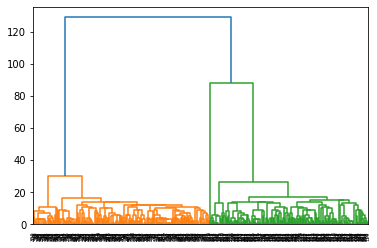

In [9]:
plot_dendrogram(x_result)

### Horizontal clustering happens at 130. 

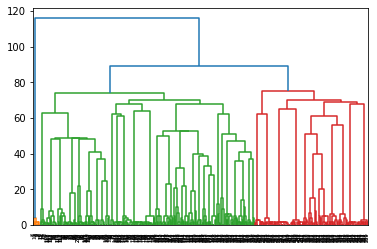

In [10]:
plot_dendrogram(y_result)

### Vertical clustering happens at 115. But not much clear.

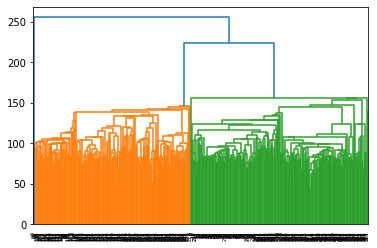

In [11]:
cumulative_matrix = np.zeros((len(x_center), 2))

for i in range(0, len(x_center)):
    cumulative_matrix[i][0] = x_center[i]
    cumulative_matrix[i][1] = y_center[i]

euc_cum = AgglomerativeClustering(n_clusters=x_clust* y_clust, affinity='euclidean', compute_distances=True ,linkage='single')
euc_result = euc_cum.fit(cumulative_matrix)
plot_dendrogram(euc_result)

### If total distance is around 250, then vertical separation must be 250/8 = 31.25. Then we can have threshold as 32

In [12]:
# import euclidean pairwise_distances
from sklearn.metrics.pairwise import pairwise_distances

horizontal_threshold = 130
vertical_threshold = 32
columns = ['Id', 'Top', 'Bottom', 'Left', 'Right', 'Top_Box', 'Bottom_Box', 'Left_Box', 'Right_Box']

# data_new = np.empty((len(x_center), len(columns)) , dtype=object)
data_new = []

for i in range(0, len(x_center)):
    id = i
    row_df = df[df['Id'] == id]
    
    top = int(row_df['Top-Left'].iloc[0].split(',')[1][:-1])
    bottom = int(row_df['Bottom-Right'].iloc[0].split(',')[1][:-1])
    left = int(row_df['Top-Left'].iloc[0].split(',')[0][1:])
    right = int(row_df['Bottom-Right'].iloc[0].split(',')[0][1:])

    top_edge = [(right+left)//2, top]
    bottom_edge = [(right+left)//2, bottom]
    left_edge = [left, (top+bottom)//2]
    right_edge = [right, (top+bottom)//2]


    top_box = [np.inf, -1] # [distance, id]
    bottom_box = [np.inf, -1]
    left_box = [np.inf, -1]
    right_box = [np.inf, -1]

    for j in range(0, len(x_center)):
        if i != j:
            if x_center_abs[i][j] < horizontal_threshold and y_center_abs[i][j] <vertical_threshold:
                dist = pairwise_distances([[x_center[i], y_center[i]]], [[x_center[j], y_center[j]]], metric='euclidean') # assuming this what they meant by distance
                if x_center[i] > x_center[j] and dist < left_box[0]:
                    left_box[0] = dist
                    left_box[1] = j
                if x_center[i] < x_center[j] and dist < right_box[0]:
                    right_box[0] = dist
                    right_box[1] = j
                if y_center[i] > y_center[j] and dist < top_box[0]:
                    top_box[0] = dist
                    top_box[1] = j
                if y_center[i] < y_center[j] and dist < bottom_box[0]:
                    bottom_box[0] = dist
                    bottom_box[1] = j
    
    if top_box[1] == -1:
        top_box = [-1,0]
    if bottom_box[1] == -1:
        bottom_box = [-1,0]
    if left_box[1] == -1:
        left_box = [-1,0]
    if right_box[1] == -1:
        right_box = [-1,0]


    data_new.append([id, top_edge, bottom_edge, left_edge, right_edge, top_box, bottom_box, left_box, right_box])


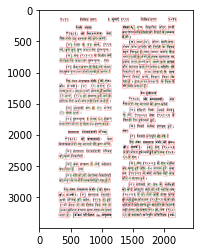

In [13]:
data_new_p = pd.DataFrame(data_new, columns = columns)
r_image = make_connections(img, data_new_p)
plt.imshow(r_image)